In [10]:
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.dates as mdates
from scipy import stats

Retrieving the data in proper DataFrames

In [11]:
# amazon DataFrames
amazon_stocks = pd.read_csv("Amazon_Stock_Data.csv", skiprows=3, names=["Date", "Adj Close","Close","High","Low","Open","Volume"])
amazon_revenue = pd.read_csv("Amazon.csv")

# alibaba DataFrames
ab_stocks = pd.read_csv("Ali_Baba_Stock_Data.csv")
ab_revenue = pd.read_csv("Alibaba.csv")

# ebay DataFrames
ebay_stocks = pd.read_csv("Ebay Stock 2025.csv")
ebay_revenue = pd.read_csv("eBay.csv")

Cleaning and preparing the DataFrames

First fixing the ebay date format

In [12]:
#ebay_stocks
def con(Date):
    try:
        date, time = str(Date).split(" ")
    except:
        return Date
    return  date
ebay_stocks["Date"] = ebay_stocks["Date"].apply(con)

Making a funciton to get the quarter of year in order to join it to the revenue dataset later on

In [13]:
def year_det(date):
    try:
        year, month, day = str(date).split("-")
    except:
        return  date
    if 1 <= int(month) <= 3:
        Q = 1
    elif 4 <= int(month) <= 6:
        Q = 2
    elif 7 <= int(month) <= 9:
        Q = 3
    else:
        Q = 4

    return f"{year} Q{Q}"

Applying the funcion to make one DataFrame for each of Amazon, Ebay, AliBaba

In [14]:
amazon_stocks["Year"] = amazon_stocks["Date"].apply(year_det)
amazon_df = pd.merge(amazon_stocks, amazon_revenue, on="Year")
amazon_df["Date"] = pd.to_datetime(amazon_df["Date"])
amazon_df = amazon_df["2019" <= amazon_df["Date"]]
amazon_df = amazon_df[["Date", "Adj Close", "Year", "Billion USD"]]

amazon_df.head()

,Date,Adj Close,Year,Billion USD
943,2019-01-02,76.956497,2019 Q1,59.7
944,2019-01-03,75.014000,2019 Q1,59.7
945,2019-01-04,78.769501,2019 Q1,59.7
946,2019-01-07,81.475502,2019 Q1,59.7
947,2019-01-08,82.829002,2019 Q1,59.7


In [15]:
ebay_stocks["Year"] = ebay_stocks["Date"].apply(year_det)
ebay_df = pd.merge(ebay_stocks, ebay_revenue, on="Year")
ebay_df["Date"] = pd.to_datetime(ebay_df["Date"])
ebay_df = ebay_df["2019" <= ebay_df["Date"]]
ebay_df = ebay_df[["Date", "Adj Close", "Year", "Billion USD"]]
ebay_df.head()

,Date,Adj Close,Year,Billion USD
1447,2019-01-02,26.067904,2019 Q1,2.41
1448,2019-01-03,25.589010,2019 Q1,2.41
1449,2019-01-04,26.176329,2019 Q1,2.41
1450,2019-01-07,26.628111,2019 Q1,2.41
1451,2019-01-08,27.107002,2019 Q1,2.41


In [16]:
ab_stocks["Year"] = ab_stocks["Date"].apply(year_det)
ab_df = pd.merge(ab_stocks, ab_revenue, on="Year")
ab_df["Date"] = pd.to_datetime(ab_df["Date"])
ab_df = ab_df["2019" <= ab_df["Date"]]
ab_df = ab_df[["Date", "Adj Close", "Year", "Billion CYD"]]
ab_df["Date"] = pd.to_datetime(ab_df["Date"])

def quarts_parsing(full):
    year, quarter = full.strip().split(" ")
    month = int(quarter[1])*3

    return pd.Timestamp(year=int(year), month=month, day=1) + pd.offsets.MonthEnd(0)

ab_df["Quarts"] = ab_df["Year"].apply(quarts_parsing)
ab_df["Date"] = pd.to_datetime(ab_df["Date"])
ab_df.head()

,Date,Adj Close,Year,Billion CYD,Quarts
1015,2019-01-02,132.017563,2019 Q1,80.9,2019-03-31
1016,2019-01-03,126.126511,2019 Q1,80.9,2019-03-31
1017,2019-01-04,134.963089,2019 Q1,80.9,2019-03-31
1018,2019-01-07,138.198349,2019 Q1,80.9,2019-03-31
1019,2019-01-08,141.761932,2019 Q1,80.9,2019-03-31


The process of gridspeccing and visualization 

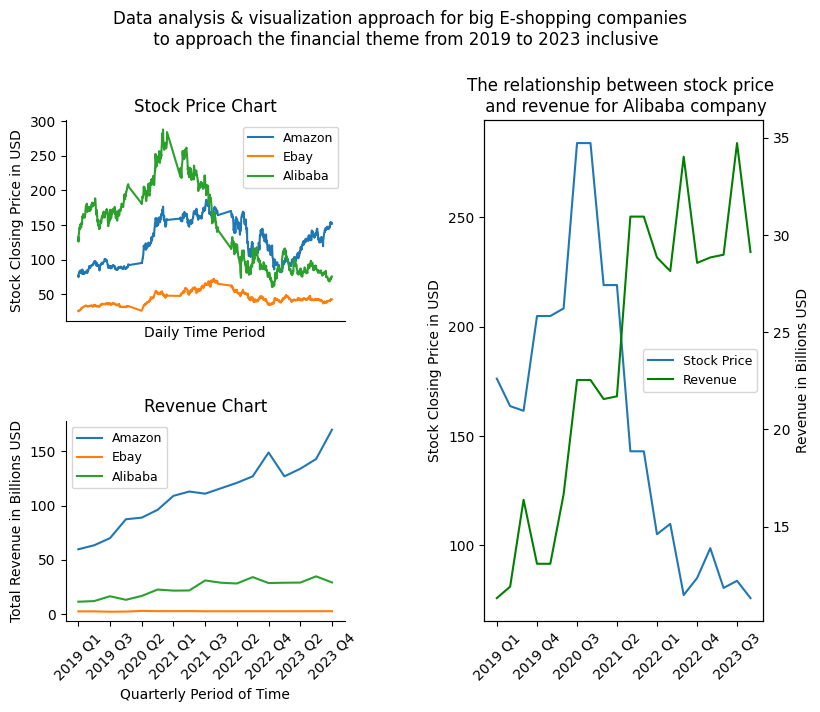

In [17]:
fig = plt.figure(figsize=(9, 6.5))

gs = GridSpec(2, 2, wspace=0.5, hspace=0.5)

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Stock Price Chart")
ax1.plot(amazon_df["Date"], amazon_df["Adj Close"], label="Amazon")
ax1.plot(ebay_df["Date"], ebay_df["Adj Close"], label="Ebay")
ax1.plot(ab_df["Date"], ab_df["Adj Close"], label="Alibaba")
ax1.set_xticks([])
ax1.legend(fontsize=9)
ax1.set_ylabel("Stock Closing Price in USD")
ax1.set_xlabel("Daily Time Period")


ax2 = fig.add_subplot(gs[1, 0])
ax2.set_title("Revenue Chart")

ax2.plot(amazon_df["Year"], amazon_df["Billion USD"], label="Amazon")
ax2.plot(ebay_df["Year"], ebay_df["Billion USD"], label="Ebay")
ax2.plot(ab_df["Year"], (ab_df["Billion CYD"].apply(lambda x: x*0.14)), label="Alibaba")
ax2.legend(fontsize=9)
plt.xticks(rotation=45)
plt.xticks(ax2.get_xticks()[::2])
ax2.set_ylabel("Total Revenue in Billions USD")
ax2.set_xlabel("Quarterly Period of Time")


new_quarters = pd.period_range(start='2019Q1', end='2023Q4', freq='Q')

ab_stock_quarters = ab_df.groupby(ab_df["Date"].dt.to_period("Q"))["Adj Close"].last()

ab_stock_quarters = ab_stock_quarters.reindex(new_quarters)

ab_stock_quarters = ab_stock_quarters.ffill()

ab_revenue_quarters = ab_df.groupby(ab_df["Date"].dt.to_period("Q"))["Billion CYD"].last()

ab_revenue_quarters = ab_revenue_quarters.reindex(new_quarters)

ab_revenue_quarters = ab_revenue_quarters.ffill()

new_ab_df = pd.DataFrame({
    "stock": ab_stock_quarters,
    "revenue": ab_revenue_quarters.apply(lambda x: x*0.14)
})

new_ab_df.index = new_ab_df.index.to_timestamp(how='end')

ax3 = fig.add_subplot(gs[:, 1])
ax3.set_title("The relationship between stock price \n and revenue for Alibaba company")
ax3l, = ax3.plot(new_ab_df.index, new_ab_df["stock"], label="Stock Price")
ax3.set_ylabel("Stock Closing Price in USD")

ax3t = ax3.twinx()

ax3tl, = ax3t.plot(new_ab_df.index, new_ab_df["revenue"], label="Revenue", color="green")
ax3t.set_ylabel("Revenue in Billions USD")
ax3.set_xticks(new_ab_df.index)
labels = [f"{one.year} Q{one.quarter}" for one in new_ab_df.index]

ax3.set_xticklabels(labels, rotation=45);
plt.xticks(ax3.get_xticks()[::3])

ax3.legend(handles=[ax3l, ax3tl], loc="center right", fontsize=9);


ax1.spines[["top", "right"]].set_visible(False)
ax2.spines[["top", "right"]].set_visible(False)

fig.suptitle("Data analysis & visualization approach for big E-shopping companies \n to approach the financial theme from 2019 to 2023 inclusive", y=1.05);

Calculating the statistical correlation and p-value

In [18]:
stat, p_val = stats.pearsonr(new_ab_df["stock"], new_ab_df["revenue"])
print(p_val)
print(stat)

0.0034418505654531225
-0.6215116747617854


These values indicate that there is no correlation between the two.